# Effective area to muon tracks

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from scipy.interpolate import RectBivariateSpline

In [2]:
with h5py.File("aeff_input_tracks/effective_area.h5", 'r') as f:
    area10 = f['2010/nu_mu/area'][()]
    bin_edges_0 = f['2010/nu_mu/bin_edges_0'][()]
    bin_edges_1 = f['2010/nu_mu/bin_edges_1'][()]

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


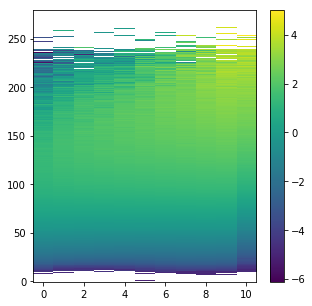

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches((5,5))
Aeff = np.sum(area10, axis=2)
plt.imshow(np.log10(Aeff), aspect='auto', origin='lower')
plt.colorbar()
bin_cen_0 = (bin_edges_0[:-1] + bin_edges_0[1:])/2
bin_cen_1 = (bin_edges_1[:-1] + bin_edges_1[1:])/2

In [4]:
spline = RectBivariateSpline(np.log10(bin_cen_0), bin_cen_1, Aeff, s=(1, 0.5))

In [5]:
out = np.zeros((280, 11))
for i, b0 in enumerate(np.log10(bin_cen_0)):
    for j, b1 in enumerate(bin_cen_1):
        out[i][j] = spline(b0, b1)
        if out[i][j] < 5e-5:
            out[i][j] = 0

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


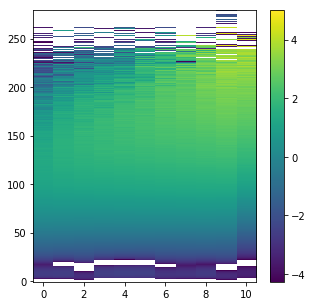

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches((5, 5))
plt.imshow(np.log10(out), aspect='auto', origin='lower')
plt.colorbar()